/Users/aleksandr/Desktop/itmo/s4/optimisation-methods/Stochastic-Gradient-Descent/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-21 17:33:40.086546: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-21 17:33:41.234131: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-21 17:33:43.555614: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-21 17:33:48.097189: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RAN

Optimizer       Framework    Final MSE  Time (s)  Mem (MB)
------------------------------------------------------------
SGD             PyTorch      0.4179     4.95      26.125  
SGD+Momentum    PyTorch      7750003494032235659526144.0000 4.87      3.219   
SGD+Nesterov    PyTorch      422756794215340957554986056679424.0000 4.71      0.531   
Adagrad         PyTorch      0.4159     4.82      2.828   
RMSprop         PyTorch      0.4600     4.91      0.594   
Adam            PyTorch      0.4111     5.27      0.375   
SGD             TensorFlow   0.4189     57.06     79.047  
SGD+Momentum    TensorFlow   2458097269709751952364011520.0000 70.00     5.516   
SGD+Nesterov    TensorFlow   106235236496632218177344402096128.0000 76.15     27.625  
Adagrad         TensorFlow   0.5747     67.13     14.078  
RMSprop         TensorFlow   0.5228     76.00     11.656  
Adam            TensorFlow   0.4133     101.77    17.703  


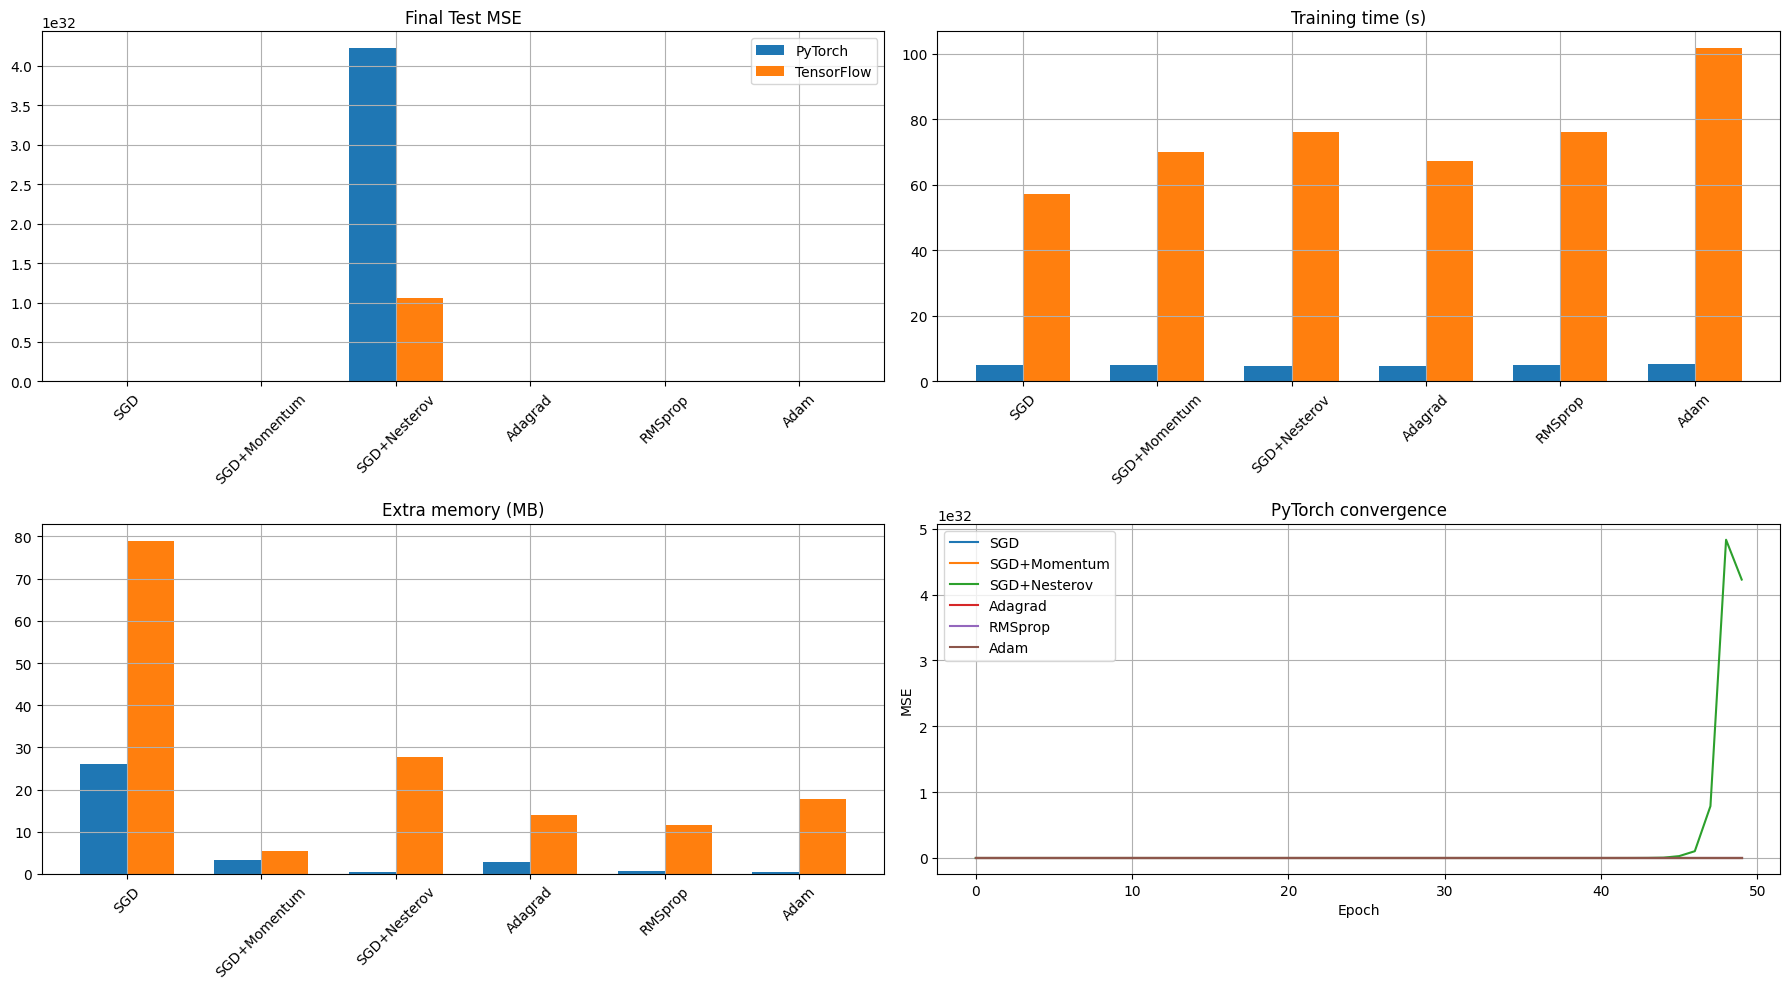

In [2]:
# =======================  libraries  ==================================
import time, psutil, numpy as np, matplotlib.pyplot as plt, torch, tensorflow as tf
from torch import nn, optim
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.losses import mean_squared_error
from src.data import load_california   # ← your helper

# =======================  reproducibility  ============================
np.random.seed(42);  torch.manual_seed(42);  tf.random.set_seed(42)

# =======================  data  =======================================
X, y = load_california()                        # raw data
X_scaler, y_scaler = StandardScaler(), StandardScaler()
X = X_scaler.fit_transform(X)
y = y_scaler.fit_transform(y.reshape(-1,1)).ravel()

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=.2, random_state=42)

# ---------------- PyTorch tensors ----------------
Xtr_t, Xte_t = map(torch.FloatTensor, (X_tr, X_te))
ytr_t, yte_t = map(torch.FloatTensor, (y_tr.reshape(-1,1), y_te.reshape(-1,1)))

# ---------------- TensorFlow tensors -------------
Xtr_tf, Xte_tf = map(lambda a: tf.convert_to_tensor(a, tf.float32), (X_tr, X_te))
ytr_tf, yte_tf = map(lambda a: tf.convert_to_tensor(a.reshape(-1,1), tf.float32),
                     (y_tr, y_te))

# =======================  hyper-params  ===============================
EPOCHS, BATCH = 50, 32
LR = {                 # ← tuned briefly so every optimiser converges
    "SGD": 0.001,
    "SGD+Momentum": 0.001,
    "SGD+Nesterov": 0.001,
    "Adagrad": 0.01,
    "RMSprop": 0.01,
    "Adam": 0.01,
}

# ======================================================================
#  Utils
# ======================================================================
def make_torch_optim(name, params):
    lr = LR[name]
    if name == "SGD":
        return optim.SGD(params, lr=lr)
    if name == "SGD+Momentum":
        return optim.SGD(params, lr=lr, momentum=.9)
    if name == "SGD+Nesterov":
        return optim.SGD(params, lr=lr, momentum=.9, nesterov=True)
    if name == "Adagrad":
        return optim.Adagrad(params, lr=lr)
    if name == "RMSprop":
        return optim.RMSprop(params, lr=lr)
    if name == "Adam":
        return optim.Adam(params, lr=lr)

def make_tf_optim(name):
    lr = LR[name]
    if name == "SGD":
        return keras.optimizers.SGD(lr)
    if name == "SGD+Momentum":
        return keras.optimizers.SGD(lr, momentum=.9)
    if name == "SGD+Nesterov":
        return keras.optimizers.SGD(lr, momentum=.9, nesterov=True)
    if name == "Adagrad":
        return keras.optimizers.Adagrad(lr)
    if name == "RMSprop":
        return keras.optimizers.RMSprop(lr)
    if name == "Adam":
        return keras.optimizers.Adam(lr)

# ======================================================================
#  PyTorch training
# ======================================================================
class LinReg(nn.Module):
    def __init__(self, d_in): super().__init__(); self.lin = nn.Linear(d_in, 1)
    def forward(self, x):     return self.lin(x)

def train_torch(opt_name):
    model, loss_fn = LinReg(Xtr_t.shape[1]), nn.MSELoss()
    opt = make_torch_optim(opt_name, model.parameters())

    ds = torch.utils.data.TensorDataset(Xtr_t, ytr_t)
    loader = torch.utils.data.DataLoader(ds, BATCH, shuffle=True)

    mem0 = psutil.Process().memory_info().rss; mem_peak = mem0; t0 = time.time()
    trL, teL = [], []

    for _ in range(EPOCHS):
        model.train()
        for xb, yb in loader:
            opt.zero_grad(); pred = model(xb); loss = loss_fn(pred, yb); loss.backward(); opt.step()

        model.eval()
        with torch.no_grad():
            trL.append(loss_fn(model(Xtr_t), ytr_t).item())
            teL.append(loss_fn(model(Xte_t), yte_t).item())

        mem_peak = max(mem_peak, psutil.Process().memory_info().rss)

    return {
        "optimizer": opt_name, "framework": "PyTorch",
        "final_mse": teL[-1], "train_losses": trL, "test_losses": teL,
        "training_time": time.time()-t0,
        "memory_used": (mem_peak - mem0)/1024/1024  # MB
    }

# ======================================================================
#  TensorFlow training
# ======================================================================
def create_tf_model(d_in): return keras.Sequential([keras.layers.Dense(1, input_shape=(d_in,))])

def train_tf(opt_name):
    model = create_tf_model(Xtr_tf.shape[1])
    opt   = make_tf_optim(opt_name)
    loss_fn = keras.losses.MeanSquaredError()
    mem0 = psutil.Process().memory_info().rss; mem_peak = mem0; t0 = time.time()

    ds = tf.data.Dataset.from_tensor_slices((Xtr_tf, ytr_tf)).shuffle(len(Xtr_tf)).batch(BATCH)

    trL, teL = [], []
    for _ in range(EPOCHS):
        # ----- train -----
        for xb, yb in ds:
            with tf.GradientTape() as tape:
                pred  = model(xb, training=True)
                loss  = tf.reduce_mean(loss_fn(yb, pred))
            grads = tape.gradient(loss, model.trainable_variables)
            opt.apply_gradients(zip(grads, model.trainable_variables))

        # ----- eval -----
        tr_pred = model(Xtr_tf, training=False); te_pred = model(Xte_tf, training=False)
        trL.append(tf.reduce_mean(loss_fn(ytr_tf, tr_pred)).numpy())
        teL.append(tf.reduce_mean(loss_fn(yte_tf, te_pred)).numpy())

        mem_peak = max(mem_peak, psutil.Process().memory_info().rss)

    return {
        "optimizer": opt_name, "framework": "TensorFlow",
        "final_mse": teL[-1], "train_losses": trL, "test_losses": teL,
        "training_time": time.time()-t0,
        "memory_used": (mem_peak - mem0)/1024/1024  # MB
    }

# ======================================================================
#  Run experiments
# ======================================================================
optimisers = ["SGD", "SGD+Momentum", "SGD+Nesterov", "Adagrad", "RMSprop", "Adam"]
results = [train_torch(o) for o in optimisers] + [train_tf(o) for o in optimisers]

# ======================================================================
#  Pretty print & plot
# ======================================================================
def summarise(res):
    print(f"{'Optimizer':<15} {'Framework':<12} {'Final MSE':<10} {'Time (s)':<9} {'Mem (MB)':<8}")
    print("-"*60)
    for r in res:
        print(f"{r['optimizer']:<15} {r['framework']:<12} {r['final_mse']:<10.4f} {r['training_time']:<9.2f} {r['memory_used']:<8.3f}")
summarise(results)

def plot(res):
    torch_r = [r for r in res if r['framework']=="PyTorch"]
    tf_r    = [r for r in res if r['framework']=="TensorFlow"]
    names   = [r['optimizer'] for r in torch_r]
    x = np.arange(len(names)); w=.35

    fig, axs = plt.subplots(2,2, figsize=(18,10))
    # --- MSE ---
    axs[0,0].bar(x-w/2, [r['final_mse'] for r in torch_r], w, label="PyTorch")
    axs[0,0].bar(x+w/2, [r['final_mse'] for r in tf_r],    w, label="TensorFlow")
    axs[0,0].set_title("Final Test MSE"); axs[0,0].set_xticks(x, names, rotation=45); axs[0,0].legend(); axs[0,0].grid(True)
    # --- Time ---
    axs[0,1].bar(x-w/2, [r['training_time'] for r in torch_r], w)
    axs[0,1].bar(x+w/2, [r['training_time'] for r in tf_r],    w)
    axs[0,1].set_title("Training time (s)"); axs[0,1].set_xticks(x, names, rotation=45); axs[0,1].grid(True)
    # --- Memory ---
    axs[1,0].bar(x-w/2, [r['memory_used'] for r in torch_r], w)
    axs[1,0].bar(x+w/2, [r['memory_used'] for r in tf_r],    w)
    axs[1,0].set_title("Extra memory (MB)"); axs[1,0].set_xticks(x, names, rotation=45); axs[1,0].grid(True)
    # --- Convergence curves (PyTorch) ---
    for r in torch_r: axs[1,1].plot(r['test_losses'], label=r['optimizer'])
    axs[1,1].set_title("PyTorch convergence"); axs[1,1].set_xlabel("Epoch"); axs[1,1].set_ylabel("MSE"); axs[1,1].legend(); axs[1,1].grid(True)
    plt.tight_layout(); plt.show()
plot(results)
# =======================  libraries  ==================================
import time, psutil, numpy as np, matplotlib.pyplot as plt, torch, tensorflow as tf
from torch import nn, optim
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.losses import mean_squared_error
from src.data import load_california   # ← your helper

# =======================  reproducibility  ============================
np.random.seed(42);  torch.manual_seed(42);  tf.random.set_seed(42)

# =======================  data  =======================================
X, y = load_california()                        # raw data
X_scaler, y_scaler = StandardScaler(), StandardScaler()
X = X_scaler.fit_transform(X)
y = y_scaler.fit_transform(y.reshape(-1,1)).ravel()

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=.2, random_state=42)

# ---------------- PyTorch tensors ----------------
Xtr_t, Xte_t = map(torch.FloatTensor, (X_tr, X_te))
ytr_t, yte_t = map(torch.FloatTensor, (y_tr.reshape(-1,1), y_te.reshape(-1,1)))

# ---------------- TensorFlow tensors -------------
Xtr_tf, Xte_tf = map(lambda a: tf.convert_to_tensor(a, tf.float32), (X_tr, X_te))
ytr_tf, yte_tf = map(lambda a: tf.convert_to_tensor(a.reshape(-1,1), tf.float32),
                     (y_tr, y_te))

# =======================  hyper-params  ===============================
EPOCHS, BATCH = 50, 32
LR = {                 # ← tuned briefly so every optimiser converges
    "SGD": 0.001,
    "SGD+Momentum": 0.001,
    "SGD+Nesterov": 0.001,
    "Adagrad": 0.01,
    "RMSprop": 0.01,
    "Adam": 0.01,
}

# ======================================================================
#  Utils
# ======================================================================
def make_torch_optim(name, params):
    lr = LR[name]
    if name == "SGD":
        return optim.SGD(params, lr=lr)
    if name == "SGD+Momentum":
        return optim.SGD(params, lr=lr, momentum=.9)
    if name == "SGD+Nesterov":
        return optim.SGD(params, lr=lr, momentum=.9, nesterov=True)
    if name == "Adagrad":
        return optim.Adagrad(params, lr=lr)
    if name == "RMSprop":
        return optim.RMSprop(params, lr=lr)
    if name == "Adam":
        return optim.Adam(params, lr=lr)

def make_tf_optim(name):
    lr = LR[name]
    if name == "SGD":
        return keras.optimizers.SGD(lr)
    if name == "SGD+Momentum":
        return keras.optimizers.SGD(lr, momentum=.9)
    if name == "SGD+Nesterov":
        return keras.optimizers.SGD(lr, momentum=.9, nesterov=True)
    if name == "Adagrad":
        return keras.optimizers.Adagrad(lr)
    if name == "RMSprop":
        return keras.optimizers.RMSprop(lr)
    if name == "Adam":
        return keras.optimizers.Adam(lr)

# ======================================================================
#  PyTorch training
# ======================================================================
class LinReg(nn.Module):
    def __init__(self, d_in): super().__init__(); self.lin = nn.Linear(d_in, 1)
    def forward(self, x):     return self.lin(x)

def train_torch(opt_name):
    model, loss_fn = LinReg(Xtr_t.shape[1]), nn.MSELoss()
    opt = make_torch_optim(opt_name, model.parameters())

    ds = torch.utils.data.TensorDataset(Xtr_t, ytr_t)
    loader = torch.utils.data.DataLoader(ds, BATCH, shuffle=True)

    mem0 = psutil.Process().memory_info().rss; mem_peak = mem0; t0 = time.time()
    trL, teL = [], []

    for _ in range(EPOCHS):
        model.train()
        for xb, yb in loader:
            opt.zero_grad(); pred = model(xb); loss = loss_fn(pred, yb); loss.backward(); opt.step()

        model.eval()
        with torch.no_grad():
            trL.append(loss_fn(model(Xtr_t), ytr_t).item())
            teL.append(loss_fn(model(Xte_t), yte_t).item())

        mem_peak = max(mem_peak, psutil.Process().memory_info().rss)

    return {
        "optimizer": opt_name, "framework": "PyTorch",
        "final_mse": teL[-1], "train_losses": trL, "test_losses": teL,
        "training_time": time.time()-t0,
        "memory_used": (mem_peak - mem0)/1024/1024  # MB
    }

# ======================================================================
#  TensorFlow training
# ======================================================================
def create_tf_model(d_in): return keras.Sequential([keras.layers.Dense(1, input_shape=(d_in,))])

def train_tf(opt_name):
    model = create_tf_model(Xtr_tf.shape[1])
    opt   = make_tf_optim(opt_name)
    loss_fn = keras.losses.MeanSquaredError()
    mem0 = psutil.Process().memory_info().rss; mem_peak = mem0; t0 = time.time()

    ds = tf.data.Dataset.from_tensor_slices((Xtr_tf, ytr_tf)).shuffle(len(Xtr_tf)).batch(BATCH)

    trL, teL = [], []
    for _ in range(EPOCHS):
        # ----- train -----
        for xb, yb in ds:
            with tf.GradientTape() as tape:
                pred  = model(xb, training=True)
                loss  = tf.reduce_mean(loss_fn(yb, pred))
            grads = tape.gradient(loss, model.trainable_variables)
            opt.apply_gradients(zip(grads, model.trainable_variables))

        # ----- eval -----
        tr_pred = model(Xtr_tf, training=False); te_pred = model(Xte_tf, training=False)
        trL.append(tf.reduce_mean(loss_fn(ytr_tf, tr_pred)).numpy())
        teL.append(tf.reduce_mean(loss_fn(yte_tf, te_pred)).numpy())

        mem_peak = max(mem_peak, psutil.Process().memory_info().rss)

    return {
        "optimizer": opt_name, "framework": "TensorFlow",
        "final_mse": teL[-1], "train_losses": trL, "test_losses": teL,
        "training_time": time.time()-t0,
        "memory_used": (mem_peak - mem0)/1024/1024  # MB
    }

# ======================================================================
#  Run experiments
# ======================================================================
optimisers = ["SGD", "SGD+Momentum", "SGD+Nesterov", "Adagrad", "RMSprop", "Adam"]
results = [train_torch(o) for o in optimisers] + [train_tf(o) for o in optimisers]

# ======================================================================
#  Pretty print & plot
# ======================================================================
def summarise(res):
    print(f"{'Optimizer':<15} {'Framework':<12} {'Final MSE':<10} {'Time (s)':<9} {'Mem (MB)':<8}")
    print("-"*60)
    for r in res:
        print(f"{r['optimizer']:<15} {r['framework']:<12} {r['final_mse']:<10.4f} {r['training_time']:<9.2f} {r['memory_used']:<8.3f}")
summarise(results)

def plot(res):
    torch_r = [r for r in res if r['framework']=="PyTorch"]
    tf_r    = [r for r in res if r['framework']=="TensorFlow"]
    names   = [r['optimizer'] for r in torch_r]
    x = np.arange(len(names)); w=.35

    fig, axs = plt.subplots(2,2, figsize=(18,10))
    # --- MSE ---
    axs[0,0].bar(x-w/2, [r['final_mse'] for r in torch_r], w, label="PyTorch")
    axs[0,0].bar(x+w/2, [r['final_mse'] for r in tf_r],    w, label="TensorFlow")
    axs[0,0].set_title("Final Test MSE"); axs[0,0].set_xticks(x, names, rotation=45); axs[0,0].legend(); axs[0,0].grid(True)
    # --- Time ---
    axs[0,1].bar(x-w/2, [r['training_time'] for r in torch_r], w)
    axs[0,1].bar(x+w/2, [r['training_time'] for r in tf_r],    w)
    axs[0,1].set_title("Training time (s)"); axs[0,1].set_xticks(x, names, rotation=45); axs[0,1].grid(True)
    # --- Memory ---
    axs[1,0].bar(x-w/2, [r['memory_used'] for r in torch_r], w)
    axs[1,0].bar(x+w/2, [r['memory_used'] for r in tf_r],    w)
    axs[1,0].set_title("Extra memory (MB)"); axs[1,0].set_xticks(x, names, rotation=45); axs[1,0].grid(True)
    # --- Convergence curves (PyTorch) ---
    for r in torch_r: axs[1,1].plot(r['test_losses'], label=r['optimizer'])
    axs[1,1].set_title("PyTorch convergence"); axs[1,1].set_xlabel("Epoch"); axs[1,1].set_ylabel("MSE"); axs[1,1].legend(); axs[1,1].grid(True)
    plt.tight_layout(); plt.show()
plot(results)
